In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, initializers

import warnings
warnings.filterwarnings("ignore")

import BjerksundStenslandModel as BS
from EnsembleNeuralNetworks import ENN
# from BlackScholesModel.py import black_scholes_call_option, black_scholes_put_option

In [2]:
# Read the data
df = pd.read_csv('/Users/gaojinglun/Desktop/RSG/data/ES_EZ.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Put.Call,Strike.Price,Settlement,Historical Vol,futures.price,Time.to.maturity,Risk.Free.Rate,Open.Interest,Implied.Volatility,Moneyness
0,C,2200,1059.0,0.008335,3259.0,0.213699,0.0154,826.0,0.338267,ITM
1,C,2250,1009.1,0.008335,3259.0,0.213699,0.0154,728.0,0.326829,ITM
2,C,2270,989.1,0.008335,3259.0,0.213699,0.0154,1.0,0.323456,ITM
3,C,2300,959.2,0.008335,3259.0,0.213699,0.0154,212.0,0.317834,ITM
4,C,2310,949.2,0.008335,3259.0,0.213699,0.0154,42.0,0.314282,ITM


In [3]:
# Set the number of estimators in the ensemble learning
n_estimators = 10

Xcol = ['futures.price', 'Strike.Price', 'Time.to.maturity', 'Risk.Free.Rate',
        'Historical Vol', 'Open.Interest', 'ATM', 'ITM', 'OTM']
Ycol = 'Implied.Volatility'

### Call Options

In [4]:
ES_EZ_call = df[df['Put.Call'] == 'C']

Call_temp = 100 * ES_EZ_call['Strike.Price'].values / ES_EZ_call['futures.price'].values
Call_ITM_idx = Call_temp < 95.2
Call_ATM_idx = np.logical_and(Call_temp <= 103.1, Call_temp >= 95.2)
Call_OTM_idx = Call_temp > 103.1

Call_moneyness = pd.get_dummies(ES_EZ_call['Moneyness'])
ES_EZ_call = pd.concat([ES_EZ_call, Call_moneyness], axis = 1)

In [5]:
ENN_Call = ENN(n_estimators = n_estimators, inputShape = 9)
ENN_Call.bootstrap(data = ES_EZ_call, 
                   stratification = ES_EZ_call['Moneyness'], trainsize = 0.8)
LR = [1e-2, 1e-3]
ENN_Call.fit(LR, Xcol, Ycol)

In [6]:
ENN_Call.get_results()

The training R^2 for model 0 is 0.9229 and 0.9231, respectively
The training R^2 for model 1 is 0.9118 and 0.9087, respectively
The training R^2 for model 2 is 0.9221 and 0.9188, respectively
The training R^2 for model 3 is 0.9566 and 0.9524, respectively
The training R^2 for model 4 is 0.953 and 0.9488, respectively
The training R^2 for model 5 is 0.9293 and 0.9295, respectively
The training R^2 for model 6 is 0.9337 and 0.9356, respectively
The training R^2 for model 7 is 0.9423 and 0.9377, respectively
The training R^2 for model 8 is 0.9326 and 0.9294, respectively
The training R^2 for model 9 is 0.955 and 0.9521, respectively


In [7]:
print('The training R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_Call.results[:,0]), 4), 
                                                          np.round(np.std(ENN_Call.results[:,0]), 4)))
print('The testing R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_Call.results[:,1]), 4), 
                                                          np.round(np.std(ENN_Call.results[:,1]), 4)))

The training R^2 for call option is 0.9359 +/- 0.0146.
The testing R^2 for call option is 0.9336 +/- 0.0139.


In [8]:
ENN_Call.results

array([[0.9229, 0.9231],
       [0.9118, 0.9087],
       [0.9221, 0.9188],
       [0.9566, 0.9524],
       [0.953 , 0.9488],
       [0.9293, 0.9295],
       [0.9337, 0.9356],
       [0.9423, 0.9377],
       [0.9326, 0.9294],
       [0.955 , 0.9521]])

In [9]:
ES_EZ_call_X = ES_EZ_call[Xcol]
ES_EZ_call_y = ES_EZ_call[Ycol]

scalerX_call = MinMaxScaler().fit(ES_EZ_call_X)
ES_EZ_call_X = pd.DataFrame(scalerX_call.transform(ES_EZ_call_X), columns = ES_EZ_call_X.columns.values) 
scalery_call = MinMaxScaler().fit(ES_EZ_call_y.values.reshape(-1, 1))
ES_EZ_call_y = scalery_call.transform(ES_EZ_call_y.values.reshape(-1, 1))

In [10]:
result1 = np.round(r2_score(ES_EZ_call_y, ENN_Call.predict(ES_EZ_call_X)), 4)
print('The total variance of call option impied volatility explained by the model is {}.'.format(result1))

The total variance of call option impied volatility explained by the model is 0.9547.


### Put Options

In [11]:
ES_EZ_put = df[df['Put.Call'] == 'P']

Put_temp = 100 * ES_EZ_put['Strike.Price'].values / ES_EZ_put['futures.price'].values
Put_ITM_idx = Put_temp > 103
Put_ATM_idx = np.logical_and(Put_temp < 103, Put_temp >= 95.2)
Put_OTM_idx = Put_temp < 95.2

put_moneyness = pd.get_dummies(ES_EZ_put['Moneyness'])
ES_EZ_put = pd.concat([ES_EZ_put, put_moneyness], axis = 1)

In [12]:
ES_EZ_put_X = ES_EZ_put[Xcol]
ES_EZ_put_y = ES_EZ_put[Ycol]

In [13]:
ENN_Put = ENN(n_estimators = n_estimators, inputShape = 9)
ENN_Put.bootstrap(data = ES_EZ_put, stratification = ES_EZ_put['Moneyness'], trainsize = 0.8)
LR = [1e-2, 1e-3]
ENN_Put.fit(LR, Xcol, Ycol)

In [14]:
ENN_Put.get_results()

The training R^2 for model 0 is 0.9416 and 0.9345, respectively
The training R^2 for model 1 is 0.9408 and 0.9419, respectively
The training R^2 for model 2 is 0.9616 and 0.9599, respectively
The training R^2 for model 3 is 0.9664 and 0.9631, respectively
The training R^2 for model 4 is 0.9497 and 0.9503, respectively
The training R^2 for model 5 is 0.9382 and 0.9316, respectively
The training R^2 for model 6 is 0.9377 and 0.9372, respectively
The training R^2 for model 7 is 0.927 and 0.9246, respectively
The training R^2 for model 8 is 0.9527 and 0.949, respectively
The training R^2 for model 9 is 0.9526 and 0.9517, respectively


In [15]:
print('The training R^2 for put option is {} +/- {}.'.format(np.round(np.mean(ENN_Put.results[:,0]), 4), 
                                                          np.round(np.std(ENN_Put.results[:,0]), 4)))
print('The testing R^2 for put option is {} +/- {}.'.format(np.round(np.mean(ENN_Put.results[:,1]), 4), 
                                                          np.round(np.std(ENN_Put.results[:,1]), 4)))

The training R^2 for put option is 0.9468 +/- 0.0114.
The testing R^2 for put option is 0.9444 +/- 0.0119.


In [16]:
ENN_Put.results

array([[0.9416, 0.9345],
       [0.9408, 0.9419],
       [0.9616, 0.9599],
       [0.9664, 0.9631],
       [0.9497, 0.9503],
       [0.9382, 0.9316],
       [0.9377, 0.9372],
       [0.927 , 0.9246],
       [0.9527, 0.949 ],
       [0.9526, 0.9517]])

In [17]:
scalerX_put = MinMaxScaler().fit(ES_EZ_put_X)
ES_EZ_put_X = pd.DataFrame(scalerX_put.transform(ES_EZ_put_X), columns = ES_EZ_put_X.columns.values) 

scalery_put = MinMaxScaler().fit(ES_EZ_put_y.values.reshape(-1, 1))
ES_EZ_put_y = scalery_put.transform(ES_EZ_put_y.values.reshape(-1, 1))

In [18]:
result2 = np.round(r2_score(ES_EZ_put_y, ENN_Put.predict(ES_EZ_put_X)), 4)
print('The total variance of put option impied volatility explained by the model is {}.'.format(result2))

The total variance of put option impied volatility explained by the model is 0.9609.


In [19]:
Call_ITM = ES_EZ_call['Settlement'][Call_ITM_idx]
Call_ATM = ES_EZ_call['Settlement'][Call_ATM_idx]
Call_OTM = ES_EZ_call['Settlement'][Call_OTM_idx]
Call_ALL = ES_EZ_call['Settlement']

Put_ITM = ES_EZ_put['Settlement'][Put_ITM_idx]
Put_ATM = ES_EZ_put['Settlement'][Put_ATM_idx]
Put_OTM = ES_EZ_put['Settlement'][Put_OTM_idx]
Put_ALL = ES_EZ_put['Settlement']

def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100* np.mean(np.abs((y_true - y_pred) / y_true))

def Call_Results(Call_Pred):
    '''
    Get the results for Call options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE 
    '''
    result = np.array([
        r2_score(Call_ITM, Call_Pred[Call_ITM_idx]),
        r2_score(Call_ATM, Call_Pred[Call_ATM_idx]),
        r2_score(Call_OTM, Call_Pred[Call_OTM_idx]),
        r2_score(Call_ALL, Call_Pred),
        
        mean_absolute_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_error(Call_ALL, Call_Pred),
        
        mean_absolute_percentage_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_percentage_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_percentage_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_percentage_error(Call_ALL, Call_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_call, x = np.abs(Call_ALL - Call_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_call, x = np.abs((Call_ALL - Call_Pred) / Call_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

def Put_Results(Put_Pred):
    '''
    Get the results for Put options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE
    '''

    result = np.array([
        r2_score(Put_ITM, Put_Pred[Put_ITM_idx]),
        r2_score(Put_ATM, Put_Pred[Put_ATM_idx]),
        r2_score(Put_OTM, Put_Pred[Put_OTM_idx]),
        r2_score(Put_ALL, Put_Pred),
        
        mean_absolute_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_error(Put_ALL, Put_Pred),
        
        mean_absolute_percentage_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_percentage_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_percentage_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_percentage_error(Put_ALL, Put_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_put, x = np.abs(Put_ALL - Put_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_put, x = np.abs((Put_ALL - Put_Pred) / Put_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

In [20]:
ENN_call = scalery_call.inverse_transform(ENN_Call.predict(ES_EZ_call_X))
ENN_put = scalery_put.inverse_transform(ENN_Put.predict(ES_EZ_put_X))

### Results

In [21]:
# Test the performances of ENN 
ENN_Call_Pred = np.zeros(ES_EZ_call.shape[0])
for i in range(ES_EZ_call.shape[0]):
    price = BS._american_option(option_type = 'c', 
                             fs = ES_EZ_call['futures.price'].values[i], 
                             x = ES_EZ_call['Strike.Price'].values[i], 
                             t = ES_EZ_call['Time.to.maturity'].values[i], 
                             r = ES_EZ_call['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_call[i])[0]
    ENN_Call_Pred[i] = price

ENN_PUT_Pred = np.zeros(ES_EZ_put.shape[0])
for i in range(ES_EZ_put.shape[0]):
    price = BS._american_option(option_type = 'p', 
                             fs = ES_EZ_put['futures.price'].values[i], 
                             x = ES_EZ_put['Strike.Price'].values[i], 
                             t = ES_EZ_put['Time.to.maturity'].values[i], 
                             r = ES_EZ_put['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_put[i])[0]
    ENN_PUT_Pred[i] = price


print('The total variance explained is {} for the Call Options'.format(
    np.round(r2_score(ES_EZ_call['Settlement'], ENN_Call_Pred), 5))
     )
print('The total variance explained is {} for the Put Options'.format(
    np.round(r2_score(ES_EZ_put['Settlement'], ENN_PUT_Pred), 5))
     )

The total variance explained is 0.99927 for the Call Options
The total variance explained is 0.99655 for the Put Options


The R^2 for ITM, ATM, OTM, and overall Call Option is 0.99949, 0.97037, 0.94185, and 0.99927, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Call Option is 4.94724, 11.45757, 7.67312, and 6.9287, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Call Option is 1.0502, 11.33804, 53.68622, and 19.35531, respectively.
--------------------------------------------------------------------------------------------------------


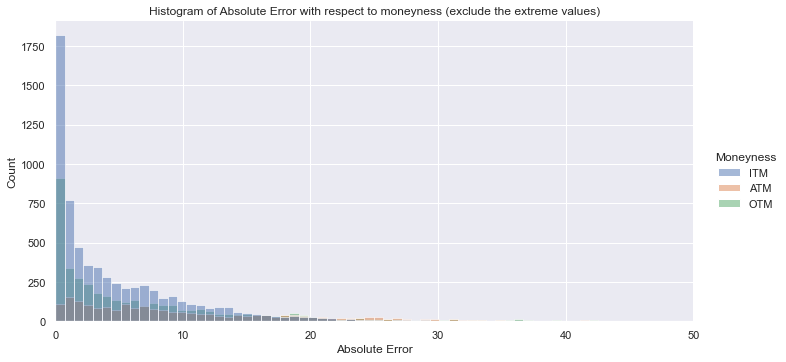

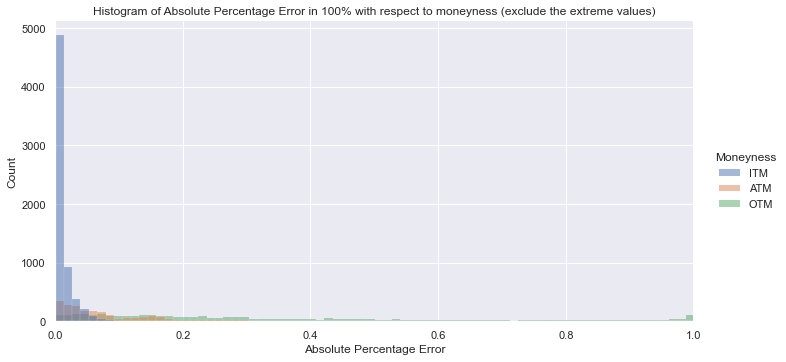

In [22]:
Call_Results(ENN_Call_Pred)

In [23]:
MAE_idx = np.argmax(np.abs(Call_ALL - ENN_Call_Pred))
print(ES_EZ_call.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAE_idx], 4))

Put.Call                      C
Strike.Price               2280
Settlement                377.1
Historical Vol        0.0347394
futures.price            2405.3
Time.to.maturity       0.260274
Risk.Free.Rate           0.0024
Open.Interest                15
Implied.Volatility     0.651075
Moneyness                   ITM
ATM                           0
ITM                           1
OTM                           0
Name: 1922, dtype: object
--------------------------------
The predicted value is 302.9935


In [24]:
MAPE_idx = np.argmax(np.abs((Call_ALL - ENN_Call_Pred) / Call_ALL))
print(ES_EZ_call.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAPE_idx], 4))

Put.Call                      C
Strike.Price               3640
Settlement                  0.2
Historical Vol         0.015363
futures.price            3380.9
Time.to.maturity      0.0958904
Risk.Free.Rate            0.016
Open.Interest               106
Implied.Volatility    0.0936499
Moneyness                   OTM
ATM                           0
ITM                           0
OTM                           1
Name: 1079, dtype: object
--------------------------------
The predicted value is 2.0062


The R^2 for ITM, ATM, OTM, and overall Put Option is 0.99522, 0.95847, 0.97932, and 0.99655, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Put Option is 8.65429, 12.281, 4.02877, and 6.21834, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Put Option is 2.71333, 12.30505, 21.37035, and 16.22075, respectively.
--------------------------------------------------------------------------------------------------------


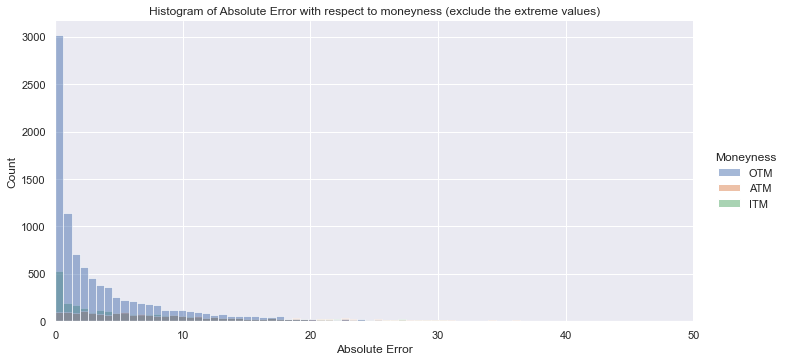

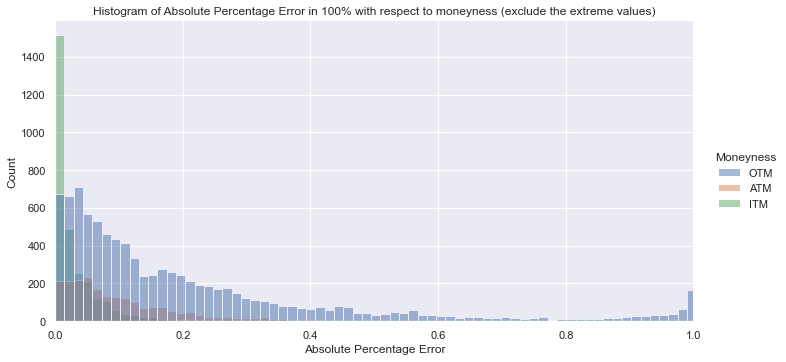

In [25]:
Put_Results(ENN_PUT_Pred)

In [26]:
MAE_idx = np.argmax(np.abs(Put_ALL - ENN_PUT_Pred))
print(ES_EZ_put.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAE_idx], 4))

Put.Call                      P
Strike.Price               2510
Settlement                  351
Historical Vol        0.0347394
futures.price            2405.3
Time.to.maturity       0.260274
Risk.Free.Rate           0.0024
Open.Interest              1005
Implied.Volatility     0.590637
Moneyness                   ITM
ATM                           0
ITM                           1
OTM                           0
Name: 15046, dtype: object
--------------------------------
The predicted value is 285.7746


In [27]:
MAPE_idx = np.argmax(np.abs((Put_ALL - ENN_PUT_Pred) / Put_ALL))
print(ES_EZ_put.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAPE_idx], 4))

Put.Call                       P
Strike.Price                3750
Settlement                   0.9
Historical Vol        0.00981027
futures.price             3967.6
Time.to.maturity       0.0109589
Risk.Free.Rate            0.0002
Open.Interest              16544
Implied.Volatility      0.239988
Moneyness                    OTM
ATM                            0
ITM                            0
OTM                            1
Name: 26845, dtype: object
--------------------------------
The predicted value is 2.1186
